Single-PE pulse shape study

Jelle, October 2017

In [72]:
# Run ID to use. You must have extracted waveforms for this
run_id = 13781
filename = 'spes_run%d_1000000.npz' % run_id
import os
if not os.path.exists(filename):
    raise FileNotFoundError("Need the file %s to run the notebook" % filename)

# Digitizer time sample width in nanoseconds
dt = 10 

# Imports, setup

In [73]:
import numpy as np
from scipy import stats, interpolate, optimize, integrate
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('latex_thesis')
%matplotlib inline

# Restore matplotlib 1.x color cycler
from cycler import cycler
matplotlib.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

from multihist import Histdd, Hist1d
import xeshape
import blueice as bi

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


In [74]:
# Get the PMT gains for the run
import hax
import logging
hax.init(pax_version_policy='loose')
logging.getLogger().setLevel(logging.INFO)
gains = np.array(hax.runs.get_run_info(run_id, 'processor.DEFAULT.gains'))

In [147]:
# Waveform plot with inset that zooms to low-amplitude region
t_range = (-50, 250)

def inset_plot(plot_orders, 
               xlabel='Time (ns) since maximum sample', 
               ylabel='Mean amplitude (fraction of total)',
               inset_zoom=0.06,
               xlim=t_range
              ):
    plot_orders()
    plt.grid(alpha=0.2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    leg = plt.legend(bbox_to_anchor=(0., .1, 1, .1))
    if leg is not None:
        leg.get_frame().set_linewidth(0.0)
        leg.get_frame().set_alpha(0.85)

    plt.xlim(*xlim)

    ax = plt.axes([.5, .55, .4, .35])
    plt.sca(ax)
    plot_orders()
    plt.ylim(*(np.array(plt.ylim()) * inset_zoom))
    plt.grid(alpha=0.2)
    plt.xlim(*t_range)
    #plt.text(150, 0.025, 'Zoom-in')
    plt.tight_layout()
    
def finish(filename=None, tight=True):
    if tight:
        plt.tight_layout()
    if filename:
        plt.savefig(filename + '.pdf')
        plt.savefig(filename + '.png', dpi=300)
        plt.savefig(filename + '.svg')
    plt.show()

# Load and clean waveform data

### Read data from file

In [76]:
d = np.load(filename)
waveforms = d['waveforms']
n_samples, _ = waveforms.shape
data = pd.DataFrame(dict(channel=d['channels']))
del d

### Remove dead PMTs

In [77]:
len(np.where(gains == 0)[0])

36

In [78]:
# Remove data from dead PMTs
mask = True ^ np.in1d(data['channel'], np.where(gains == 0)[0])
data = data[mask]
waveforms = waveforms[:,mask]

In [79]:
from collections import Counter
counts = np.array(Counter(data['channel']).most_common())

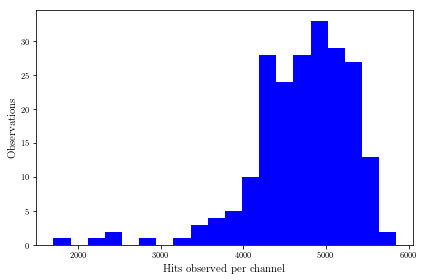

In [80]:
plt.hist(counts[:, 1], bins=20);
counts[0], counts[-1], counts.mean(axis=0)[1]
plt.xlabel("Hits observed per channel")
plt.ylabel("Observations")
finish('channel_distribution')

Looks like relatively evenly distributed

### Cut away noise at edges

In [81]:
# Find range of interest 
ts = (np.arange(n_samples) - n_samples//2) * dt    # Waveform comes centered from pax
mask = (t_range[0] <= ts) & (ts <= t_range[1])
ts = ts[mask]

In [82]:
waveforms = waveforms[mask, :]

### Normalize

In [83]:
data['area'] = waveforms.sum(axis=0)    # Waveform area in adc counts
waveforms = waveforms.astype(np.float) / data['area'][np.newaxis, :]

### Areas -> PE, select approx. 1 PE waveforms

In [84]:
# Get conversion factor to electrons
from pax import dsputils, configuration
pax_config = configuration.load_configuration('XENON1T')
adc_to_e = dsputils.adc_to_pe(pax_config['DEFAULT'], 0, use_reference_gain=True) * 2e6

In [85]:
# Convert areas to PE
data['area'] *= adc_to_e / gains[data['channel']]

In [86]:
np.median(gains), 15 * adc_to_e / np.median(gains), 15 * adc_to_e / np.median(gains) / 0.4

(2439931.8799999999, 0.10538911485969886, 0.26347278714924716)

In [87]:
area_bounds = (0.5, 1.8)

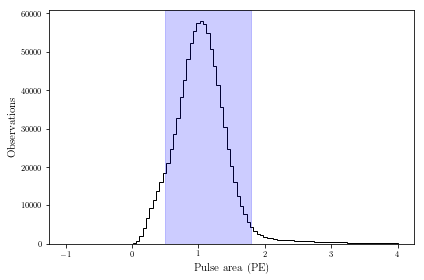

In [88]:
plt.hist(data['area'], bins=np.linspace(-1, 4, 100), histtype='step', color='k');
plt.axvspan(*area_bounds, color='blue', alpha=0.2)
plt.xlabel("Pulse area (PE)")
plt.ylabel("Observations")
finish('area_selection')

In [89]:
mask = ((area_bounds[0] < data['area']) & (data['area'] < area_bounds[1])).values

In [90]:
mask.sum()/len(mask)

0.87947299999999995

In [91]:
data = data[mask]
waveforms = waveforms[:, mask]

In [92]:
len(data)

879473

### Compute mean template

In [93]:
mean_template = waveforms.mean(axis=1)
median_template = np.median(waveforms, axis=1)

# Study Per-channel templates

### Extract per-ch templates

In [94]:
# Overall mean template
mean_template = waveforms.mean(axis=1)

# Get per-channel templates
from tqdm import tqdm
from collections import OrderedDict
per_ch_templates = OrderedDict()
for ch in tqdm(np.sort(np.unique(data['channel'].values))):
    ch_wvs = waveforms[:,(data['channel'] == ch).values]
    q = dict(mean=ch_wvs.mean(axis=1),
             median=np.median(ch_wvs, axis=1),
             std=ch_wvs.std(axis=1),
             channel=ch,
             n=len(ch_wvs[0]))
    q['error'] = q['std'] / q['n']**0.5
    
    # Some statistics to look for outliers
    q['ks'] = np.max(np.abs(np.cumsum(q['mean']) - np.cumsum(mean_template)))
    q['rms_dif'] = np.sum((q['mean'] - mean_template)**2)**0.5
    
    per_ch_templates[ch] = q

per_ch_data = pd.DataFrame(per_ch_templates).T

100%|██████████| 212/212 [00:01<00:00, 121.94it/s]


### FInd unusual channels

In [95]:
gains[208]

2431951.0789999999

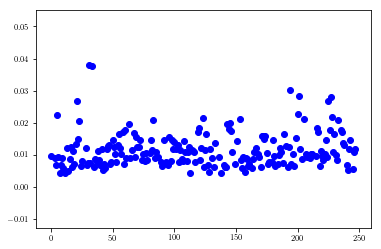

In [96]:
plt.scatter(per_ch_data['channel'], per_ch_data['rms_dif'])

31 1109
33 4065
205 4042
31 1109
33 4065
205 4042


/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


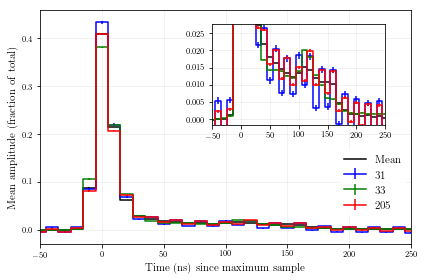

In [97]:
def plot_per_channel():
    for ch, d in per_ch_data.iterrows():
        if not ch in [31, 33, 205]:
        #if d['rms_dif'] < 0.032:
            continue
        print(ch, d['n'])
        plt.errorbar(ts, d['mean'], 
                     yerr=d['error'],
                     linestyle='steps-mid', 
                     label=ch)
    plt.plot(ts, mean_template, c='k', linestyle='steps-mid', label='Mean')
        
inset_plot(plot_per_channel)
finish('weird_ch_waveforms')

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


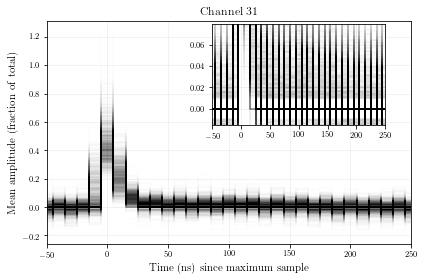

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


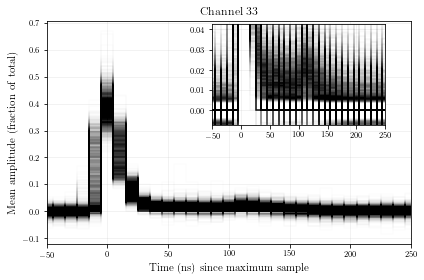

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


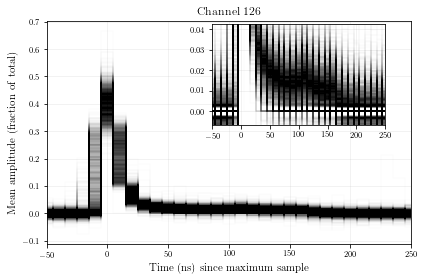

In [98]:
for examine_ch in [31, 33, 126]:
    def examine_channel():
        ch_wvs = waveforms[:,(data['channel'] == examine_ch).values]
        n_wvs = ch_wvs.shape[1]
        for i in range(n_wvs):
            plt.plot(ts, ch_wvs[:, i], alpha=0.01, c='k', linestyle='steps-mid')

    plt.title("Channel %d" % examine_ch)
    inset_plot(examine_channel)
    finish('examine_ch_%d' % examine_ch)

In [99]:
gains[31], gains[205]

(1021081.003, 1450886.0730000001)

In [100]:
#gains[np.argsort(gains)][:80]

 * Channel 31 and 205 show pronounced 1-sample alternating noise. This is somewhat puzzling as lone hits should fall randomly with respect to any noise. However, since these channels have an unusually low gain (1.02e6 and 1.45e6, respectively) the ADC threshold might be relevant for this channel: high-frequency noise can make it more likely to detect hits that occur in phase with this noise. We will remove these channels from consideration.
 * Channel 33 shows a pronounced secondary spike at ~115 ns. Waveforms (and the median template) confirm these are not just rare secondary hits like afterpulses, but a true after-affect of ordinary hits. 

### Remove channel 31, recompute template

In [101]:
exclude_channels = [31, 33, 205]
mask = True ^ np.in1d(data['channel'].values, exclude_channels)

# Cut data from the bad channels
data = data[mask]
waveforms = waveforms[:, mask]

In [102]:
mean_template = waveforms.mean(axis=1)
median_template = np.median(waveforms, axis=1)

In [103]:
for ch in exclude_channels:
    del per_ch_templates[ch]
per_ch_data = pd.DataFrame(per_ch_templates).T

In [104]:
#per_ch_templates[33]

### Worth re-weighting template?

In [105]:
good_channels = np.array(list(per_ch_templates.keys()))
per_ch_means = np.vstack(per_ch_data['mean'].values)
weighted_mean = per_ch_means.mean(axis=0)
err_on_w_mean = per_ch_means.std(axis=0) / len(per_ch_templates)**0.5

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


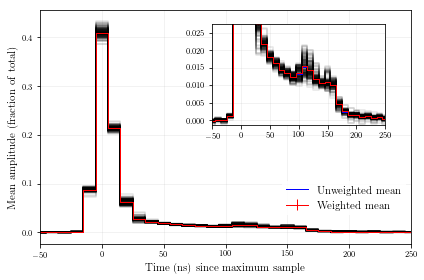

In [106]:
def bla():
    for q in per_ch_means:
        plt.plot(ts, q, alpha=0.1, c='k', linestyle='steps-mid')
    plt.errorbar(ts, weighted_mean, 
                 yerr=err_on_w_mean,
                 linestyle='steps-mid', label='Weighted mean', linewidth=1, c='r')
    plt.plot(ts, mean_template, linestyle='steps-mid', label='Unweighted mean', linewidth=1)
    
inset_plot(bla)
finish('reweighting_comparison')

Per-channel weighting gives an essentially identical result as just averaging all lone hits. I'll keep using the latter since it's simpler.

### Origin of spikes

In [107]:
#np.where(x > 0.013)[0].tolist()

In [108]:
assert len(good_channels) == len(per_ch_means) == len(per_ch_templates)

In [109]:
hax.pmt_plot.pmt_data.keys()

Index(['amplifier:crate', 'amplifier:fan', 'amplifier:plug',
       'amplifier:serial', 'amplifier:slot', 'array', 'digitizer:channel',
       'digitizer:crate', 'digitizer:module', 'digitizer:slot',
       'high_voltage:channel', 'high_voltage:connector',
       'high_voltage:feedthrough', 'high_voltage:return', 'pmt_position',
       'position:x', 'position:y', 'serial_number', 'signal:channel',
       'signal:connector', 'signal:feedthrough'],
      dtype='object')

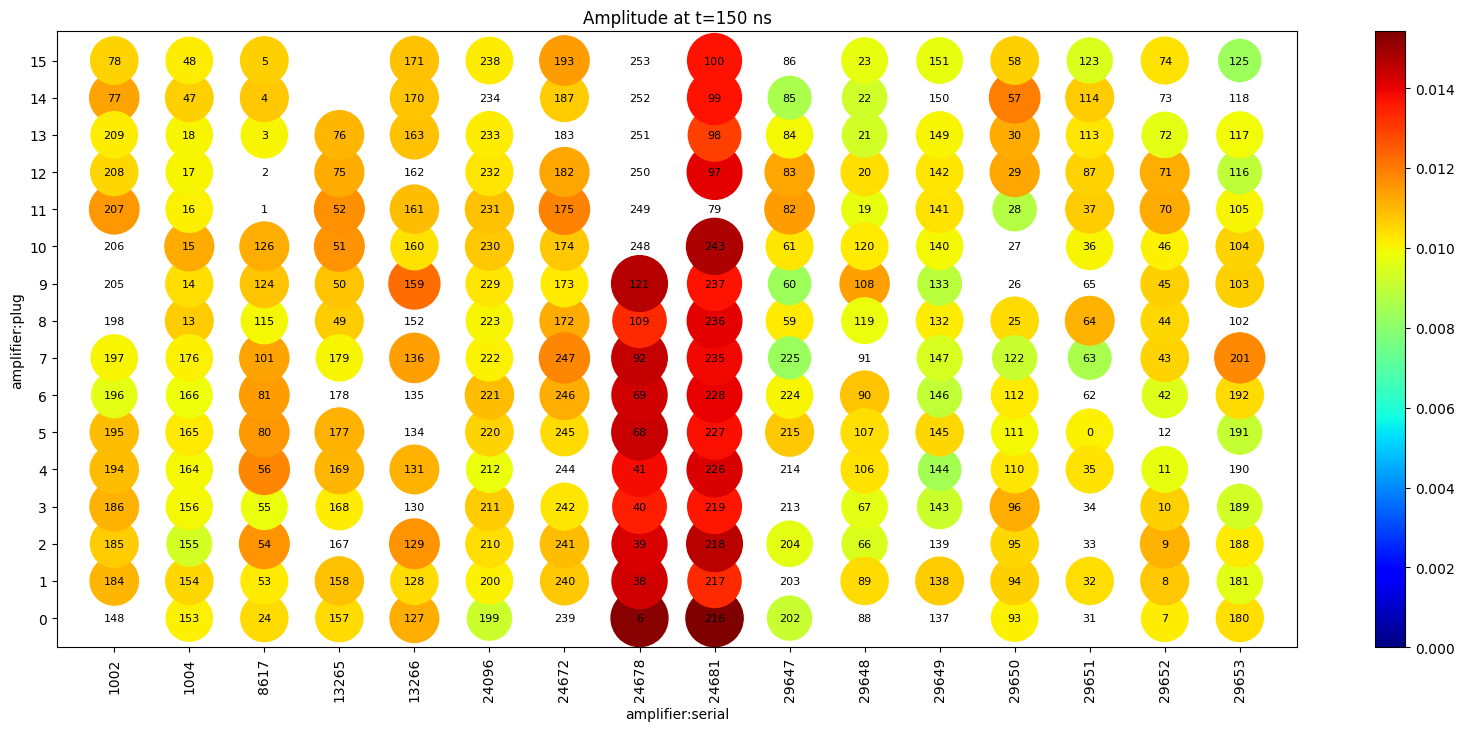

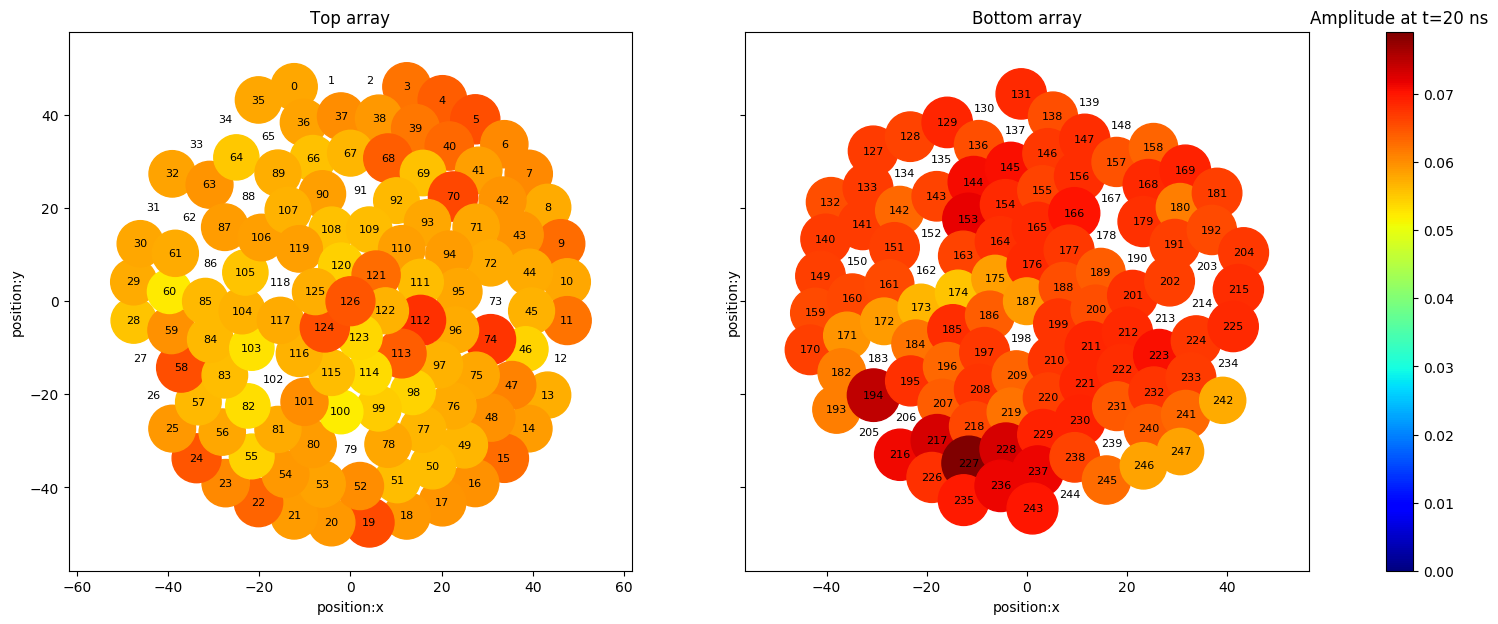

In [110]:
plt.style.use('default')

per_ch_means = np.vstack(per_ch_data['mean'].values)
for examine_t, geometry in [
        (150, 'amplifier'), 
        #(20, 'physical'), (20, 'high_voltage'), 
        (20, 'physical'),
    
        #(150, 'high_voltage'), (150, 'physical')
        #(10, 'amplifier'), (-10, 'amplifier')
        ]:
    x = np.zeros(249)
    t_ind = np.where(examine_t == ts)[0][0]
    for i in range(len(x)):
        if i in good_channels:
            x[i] = per_ch_means[np.where(good_channels == i)[0], t_ind].sum()

    hax.pmt_plot.plot_on_pmt_arrays(x, geometry=geometry, scatter_kwargs=dict(cmap=plt.cm.jet))
    plt.title("Amplitude at t=%d ns" % examine_t)
    finish('examine_t_%d_%s.pdf' % (examine_t, geometry), tight=False)

# Tried adding two samples
# for examine_t_l, examine_t_r, geometry in [(110, 120, 'signal'), (150, 150, 'amplifier')]:
#     x = np.zeros(249)
#     inds = np.where((examine_t_l <= ts) & (ts <= examine_t_r))[0]
#     print(inds)
#     for i in range(len(x)):
#         if i in good_channels:
#             x[i] = per_ch_means[np.where(good_channels == i)[0], inds].sum()

#     hax.pmt_plot.plot_on_pmt_arrays(x, geometry=geometry, scatter_kwargs=dict(cmap=plt.cm.jet))
#     plt.title("Amplitude at t=%d ns" % examine_t_l)
#     plt.show()

110 ns: Not clear. Some correlation with high voltage and signal geometry, but also just low PMT numbers (top array).

150 ns: clearly related to two amplifiers (24678, 24681). Reflection in cable due to impedance mismatch.

In [111]:
plt.style.use('latex_thesis')

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))



# Look at template

In [112]:
len(data), len(waveforms[0])

(870257, 870257)

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


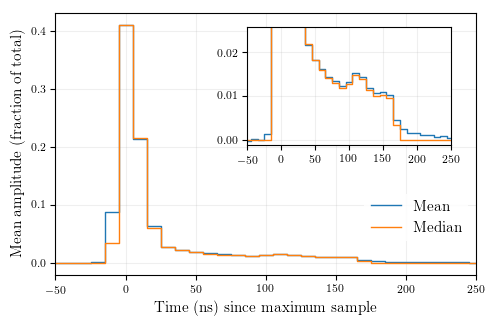

In [113]:
   def show_data():
    plt.plot(ts, mean_template, linestyle='steps-mid', label='Mean', linewidth=1)
    plt.plot(ts, median_template, linestyle='steps-mid', label='Median', linewidth=1)
    
inset_plot(show_data)
finish('median_vs_mean')

In [114]:
# Fraction of charge after 50 ns
for q in mean_template, median_template:
    print(q[(ts > 50)].sum())

0.15712940321
0.141551957773


# Fit underlying shape model

### Blueice / xeshape integration

In [115]:
class SPEWaveformSource(xeshape.bi.WaveformSource):

    def __init__(self, config, *args, **kwargs):
        self.pmt_pulse = self.get_pmt_pulse(config)
        xeshape.bi.WaveformSource.__init__(self, config, *args, **kwargs)
        
    def simulate_wv_matrix(self, n_events):
        n_samples = len(self.ts)
        wv_matrix = np.zeros((n_samples, n_events))
        zero_index = np.where(self.ts == 0)[0][0]
        
        # feed shifted versions to digitizer response
        for i, offset in enumerate(np.linspace(0, dt, n_events)):
            wv_matrix[:, i] = xeshape.simulator.digitizer_response(
                self.pmt_pulse, 
                offset=offset, 
                dt=self.dt,
                samples_before=zero_index, 
                samples_after=n_samples - zero_index)
        
        return wv_matrix
       
    
def spe_matching_likelihood(pmt_pulse_factory, ts, shape_parameters=None, **kwargs):
    if shape_parameters is None:
        shape_parameters = dict()
    
    # Rig up a dummy SPE class
    class TempSPESource(SPEWaveformSource):
        pass
    
    TempSPESource.get_pmt_pulse = lambda self, config : pmt_pulse_factory(config)
    
    # Blueice model config
    config = dict(
        sources=[dict(name='SPEs')],
        analysis_space=(('t', ts),),
        default_source_class=TempSPESource,
        n_events_for_model=int(100),
        force_recalculation=True,
        never_save_to_cache=True,
    )
    config.update(kwargs)
    for k, v in shape_parameters.items():
        # Have to set some default for the shape parameters...
        config.setdefault(k, v[0])
    
    # Build blueice likelihood
    ll = xeshape.bi.WaveformLikelihood(config)
    for k, v in shape_parameters.items():
        ll.add_shape_parameter(k, v)
        
    ll.prepare()
    
    return config, ll

### Interpolated integral

In [116]:
def interpolated_normalized_integral(ts, ys, kind='linear'):
    """Return interpolated normalized integral of function given at ts and ys.
    First sample of ys must be zero. Sorry.
    
    kind can be:
     'delta': function is assumed to be a series of delta functions (one at each of ts).
     'step': function is assumed to be a step function (step at each of ts).
     'linear': function is assumed to be a linear interpolation.
    """
    assert kind in ['delta', 'step', 'linear']
    assert len(ts) == len(ys)

    cumsum = np.cumsum(ys)
    d_ys = np.diff(ys)
    d_ts = np.diff(ts)
    slopes = d_ys/d_ts
    
    area_scale = np.sum(ys[1:] * dt)

    
    if kind == 'linear':
        # Cumsum of areas of little triangles between step function and linear interpolation
        triangle_areas_cumsum = np.cumsum(0.5 * slopes * d_ts**2)
        triangle_areas_cumsum /= area_scale    # Proper scaling for area
    
    def pmt_pulse(t):      
        result = np.zeros(len(t), dtype=np.float)
        
        # Compute indices of ts (anchor points) nearest left of t
        inds = np.searchsorted(ts, t)
        result[inds == 0] = 0
        result[inds == len(ts)] = 1
        in_range = True ^ ((inds == 0) | (inds == len(ts)))            
        inds -= 1
        inds = inds[in_range]
        
        # Index of anchor BEFORE the nearest left
        inds_prev = np.clip(inds - 1, 0, None)
        
        if kind == 'delta':
            result[in_range] += cumsum[inds]
            return result
        
        # For all bins before the current, we get the full area
        result[in_range] += cumsum[inds_prev]
        
        # Distance from nearest left
        dt = t[in_range] - ts[inds]

        # Area of rectangle
        result[in_range] += ys[inds] * dt / area_scale
        
        if kind == 'step':
            return result
        
        # Area of triangle
        result[in_range] += 0.5 * slopes[inds] * dt**2 / area_scale
        
        # Area of previous triangles
        result[in_range] += triangle_areas_cumsum[inds_prev]

        return result
            
    return pmt_pulse
            

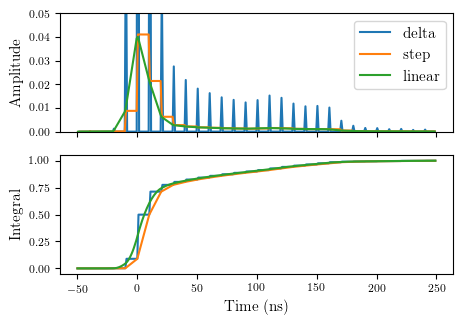

In [117]:
interpolated_normalized_integral(ts, mean_template, kind='linear')

hr_ts = np.arange(ts.min(), ts.max(), 1)
hr_t_centers = 0.5*(hr_ts[1:]+hr_ts[:-1])
    
f, axes = plt.subplots(2, sharex=True)
for kind in 'delta step linear'.split():
    ys = interpolated_normalized_integral(ts, mean_template, kind=kind)(hr_ts)
    axes[0].plot((hr_ts[1:]+hr_ts[:-1])/2, np.diff(ys), label=kind)
    axes[1].plot(hr_ts, ys)
    
axes[0].set_ylim(0, 0.05)
axes[0].legend(loc='upper right')
axes[0].set_ylabel("Amplitude")
axes[1].set_ylabel("Integral")
axes[1].set_xlabel("Time (ns)")
#plt.plot(hr_ts, interpolated_normalized_integral(ts, mean_template, kind='linear')(hr_ts))

### Try several templates

In [151]:
# Simple models: interpolations of templates we just got
models = OrderedDict()
for kind in 'delta step linear'.split():
    pmt_pulse = interpolated_normalized_integral(ts, mean_template, kind=kind)
    # Note scope hack for keeping things in lambda constant below, see https://stackoverflow.com/questions/2295290
    models[kind + '_template'] = dict(pmt_pulse_factory=lambda config, pmt_pulse=pmt_pulse: pmt_pulse,
                                      label=kind.capitalize() + ' template')


# Functional model: Expongauss + box
def expgauss_box(c):
    dist = stats.exponnorm(c['shape'], loc=0, scale=c['scale'])
    def f(t):
        t = np.asarray(t)
        y = dist.cdf(t) * (1 - c['f_box'])
        y += np.clip(t/c['box_end'], 0, 1) * c['f_box']
        return y
    return f


models['expgauss_box'] = dict(
    pmt_pulse_factory=expgauss_box,
    shape_parameters=dict(scale=np.linspace(0.5, 3, 5),
                          shape=np.linspace(5, 10, 5),
                          box_end=np.linspace(160, 190, 5),
                          f_box=np.linspace(0.1, 0.3, 5)
                         ),
    label='ExpGauss + Box'
)


def expgauss_template(c):
    mask = hr_ts > c['t_switch']
    
    dist = stats.exponnorm(c['shape'], loc=0, scale=c['scale'])
    y = dist.pdf(hr_ts)
    y /= y[~mask].sum() * c['norm_adjust']
    
    y[mask] = interpolate.interp1d(ts, mean_template)(hr_ts[mask])
    
    y /= y.sum()
    
    return interpolated_normalized_integral(hr_ts, y, kind='linear')

    
models['expgauss_template'] = dict(
    pmt_pulse_factory=expgauss_template,
    shape_parameters=dict(scale=np.linspace(1, 2, 5),
                          shape=np.linspace(6, 10, 5),
                          norm_adjust=np.linspace(0.1, 0.2, 5),
                          t_switch=np.linspace(20, 26, 5)
                         ),
    label='ExpGauss + Template'
)
            
for mname, d in models.items():
    d['config'], d['ll'] = spe_matching_likelihood(d['pmt_pulse_factory'], ts, d.get('shape_parameters'))
    d['ll'].set_data(waveforms)
    
    if not len(d['ll'].shape_parameters):
        d['fit_results'] = dict()
        d['ks'] = d['ks_itp'] = d['ll']()
        d['bestfit_model'] = d['ll'].base_model
    
    else:
        d['fit_results'], d['ks_itp'] = d['ll'].bestfit_scipy(guess=d['ll'].best_anchor())
    
        # Compute KS-statistic for the best fit, from a from-scratch model (no interpolation)
        d['bestfit_model'] = bi.Model(d['config'], **d['fit_results'])
        ll = xeshape.bi.WaveformLikelihood(d['config'], **d['fit_results'])
        ll.prepare()
        ll.set_data(waveforms)
        d['ks'] = ll()
    

Computing/loading models on one core: 100%|██████████| 625/625 [00:06<00:00, 98.85it/s]


In [152]:
#p = expgauss_template(dict(scale=5, shape=1, norm_adjust=0.2, t_switch=30))
#plt.plot(hr_ts[:-1], np.diff(p(hr_ts)))

### Compare results

In [153]:
# KS statistics:
for _, d in models.items():
    print(d['label'].ljust(20), ': %0.4f (itp), %0.4f (full)' % (d['ks_itp'], d['ks']))

Delta template       : -0.0000 (itp), -0.0000 (full)
Step template        : -0.0722 (itp), -0.0722 (full)
Linear template      : -0.0888 (itp), -0.0888 (full)
ExpGauss + Box       : -0.0082 (itp), -0.0088 (full)
ExpGauss + Template  : -0.0038 (itp), -0.0038 (full)


In [154]:
alpha=0.5
c_a = (-0.5 * np.log(alpha/2))**0.5
c_a**2 * 2/models['expgauss_template']['ks']**2

95232.109401626833

In [155]:
models['expgauss_template']['fit_results']

OrderedDict([('t_switch', 20.515275541699275),
             ('norm_adjust', 0.14802890998916468),
             ('shape', 9.1258943701302666),
             ('scale', 1.2232689772231082)])

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


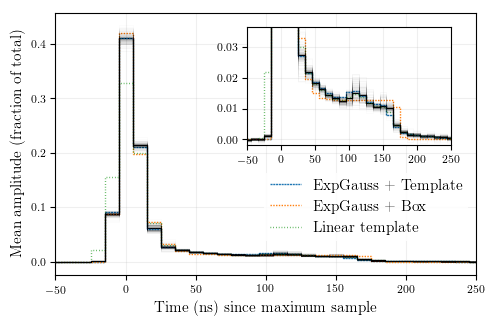

In [158]:
def show_gof():
    plt.plot(ts, mean_template, 
             c='k', linewidth=1, drawstyle='steps-mid',
             #label='Data mean'
            )
    
    mshow = [d for d in models.values() 
             if not ('Delta' in d['label'] or 'Step' in d['label'])]
    
    nshow = len(mshow)
    for i, d in enumerate(reversed(mshow)):
        plt.plot(ts, d['bestfit_model'].sources[0].waveform_model,
                 label=d['label'],
                 drawstyle='steps-mid', 
                 dashes=((nshow - i)/(nshow + 1), (i + 1)/(nshow + 1)),
                 linewidth=1
                )
    for q in per_ch_means:
        plt.plot(ts, q, alpha=0.01, c='k', linestyle='steps-mid',  linewidth=0.7)

inset_plot(show_gof, inset_zoom=0.08)
finish('pulse_model_fit')

### Show underlying shape

In [159]:
frs = models['expgauss_box']['fit_results']
print("ExponGauss: %0.1f ns decay time, %0.1f ns sigma" % ((frs['scale'] * frs['shape']), frs['scale']))
print("\tBox ends at %0.1f ns, %0.1f%% of charge" % (frs['box_end'], 100 * frs['f_box']))

frs = models['expgauss_template']['fit_results']
print("ExponGauss: %0.1f ns decay time, %0.1f ns sigma" % ((frs['scale'] * frs['shape']), frs['scale']))
print("\tModel takes over at %0.1f ns, %0.3f normadjust" % (frs['t_switch'], frs['norm_adjust']))

ExponGauss: 9.0 ns decay time, 1.1 ns sigma
	Box ends at 178.6 ns, 23.0% of charge
ExponGauss: 11.2 ns decay time, 1.2 ns sigma
	Model takes over at 20.5 ns, 0.148 normadjust


/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


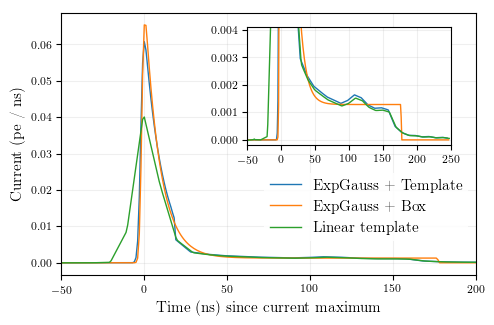

In [163]:
hr_ts = np.arange(ts.min(), ts.max(), 1)
hr_t_centers = 0.5*(hr_ts[1:]+hr_ts[:-1])
for _, d in models.items():
    y = np.diff(d['bestfit_model'].sources[0].pmt_pulse(hr_ts))
    y *= y.sum()/(hr_ts[1]-hr_ts[0])
    d['hr_y'] = y
    d['cog'] = np.average(hr_t_centers, weights=y)

def show_real_model():
    for _, d in reversed(list(models.items())):
        if 'Step' in d['label'] or 'Delta' in d['label']:
            continue
        
        plt.plot(hr_t_centers - hr_t_centers[np.argmax(d['hr_y'])],
                 d['hr_y'],
                 label=d['label'], linewidth=1)

inset_plot(show_real_model, 
           xlabel='Time (ns) since current maximum', 
           ylabel='Current (\si{pe / ns})', xlim=(-50, 200))
finish('recon_current')

### Extract fax config

In [126]:
mask = (hr_ts < 200) & (hr_ts > -10)  # no need to simulate stuff past box end

ys_fax = models['expgauss_template']['hr_y'][mask]
ts_fax = hr_ts[mask]
ts_fax -= ts_fax[np.argmax(ys_fax)]  # Ensure maximum is at 0

fax_conf = """
# Custom PMT model extracted from data.
# See [link to note]
# interp1d(pe_pulse_ts, pue_pulse_ys) must give a function mapping time since max in ns -> amplitude
# Scale of ys is irrelevant, will be rescaled (by integration) at startup.
pe_pulse_model = 'custom'
pe_pulse_ts = {ts_fax}
pe_pulse_ys = {ys_fax}
samples_before_pulse_center = 2
samples_after_pulse_center = 20
""".format(ts_fax=ts_fax, ys_fax=ys_fax)

print(fax_conf)


# Custom PMT model extracted from data.
# See [link to note]
# interp1d(pe_pulse_ts, pue_pulse_ys) must give a function mapping time since max in ns -> amplitude
# Scale of ys is irrelevant, will be rescaled (by integration) at startup.
pe_pulse_model = 'custom'
pe_pulse_ts = [-12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5
   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23
  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 299 but corresponding boolean dimension is 300
  app.launch_new_instance()


In [127]:
np.savez('x1t_sr1_spe.npz', ts=ts_fax, ys=ys_fax)

### Compute rise and fall time of ExpGauss part

According to the XENON1T.ini file, Daniel Mayani observed a rise time of 3 ns and fall time of 10 ns with a Fall time of 10 ns. 

In [128]:
f = stats.exponnorm(frs['shape'], loc=0, scale=frs['scale'])
y = f.pdf(hr_ts)
max_y = max(y)
max_t = hr_ts[np.argmax(y)]

timings = {}
for side in 'lr':
    mask = {'l':False, 'r':True}[side] ^ (hr_ts < max_t)
    for a in [0.1, 0.9]:
        timings[(side, a)] = hr_ts[mask][np.argmin(np.abs(y[mask] - a * max_y))] - max_t


In [129]:
timings[('l', 0.9)] - timings[('l', 0.1)]

3

In [130]:
timings[('r', 0.1)] - timings[('r', 0.9)]

24

While rise time seems consistent with scope measurement, fall time is not. Not really surprising, model of late-time component is quite rough.

# Other stuff for bonus points

### Look for outlying waveforms

In [131]:
difs = waveforms - mean_template[:, np.newaxis]

In [132]:
data['rmsdif'] = (np.sqrt(np.mean(difs**2, axis=0)))**0.5
data['maxdif'] = np.max(np.abs(difs), axis=0)

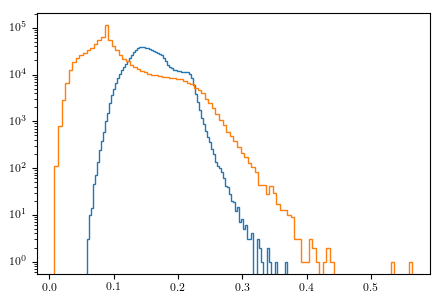

In [133]:
plt.hist(data['rmsdif'], bins=100, histtype='step');
plt.hist(data['maxdif'], bins=100, histtype='step');
plt.yscale('log')
plt.show()

In [134]:
# from collections import Counter
# (a, _) = Counter(data['maxdif']).most_common()[0]

In [135]:
# plt.hist(data['maxdif'], bins=np.linspace(0.086, 0.087, 100), histtype='step');

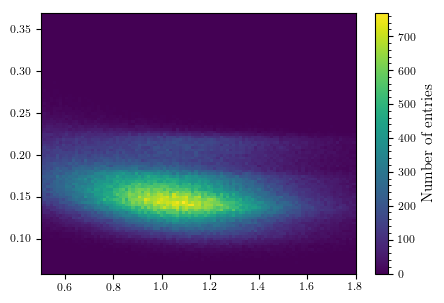

In [136]:
Histdd(data['area'], data['rmsdif'], bins=100).plot()
plt.show()

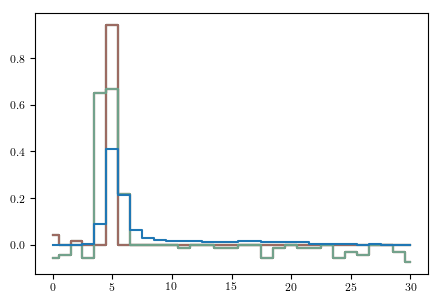

In [137]:
inds = np.where((data['maxdif'] > 0.5))[0]
for i in np.random.choice(inds, 20):
    plt.plot(waveforms[:, i], alpha=0.4, linestyle='steps-mid')
plt.plot(mean_template, linestyle='steps-mid')

Few waveforms with declining baseline, one (blue one) which is a bit odd.

### Offset estimate from center of gravity

Can we use the center of gravity (computed on the central samples) as a sub-dt arrival time estimate?

In [138]:
# Compute COG from the central indices
zero_i = np.where(ts == 0)[0][0]
irange = slice(zero_i - 2, zero_i + 4)
data['cog'] = (np.arange(n_samples)[irange, np.newaxis] * waveforms[irange, :]
               / waveforms[irange, :].sum(axis=0)).sum(axis=0)
#data['offset_est_cog'] = (data['cog'] - zero_i) * dt + 2.5

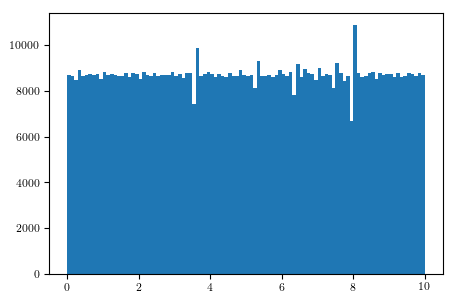

In [139]:
# Convert to cumulant, multiply by dt = 10
h_offset = Hist1d(data['cog'], bins=10000)
h_offset.histogram = h_offset.cumulative_density
data['offset_est_cog'] = 10 * h_offset.lookup(data['cog'])
plt.hist(data['offset_est_cog'], bins=100)
plt.show()

In [140]:
maxn = 10000
wvs = waveforms[:, :maxn]

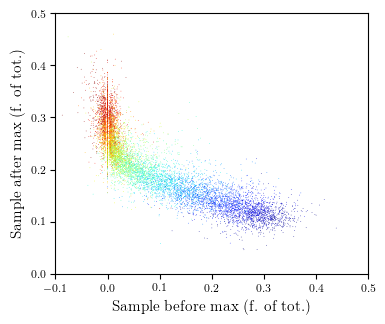

In [141]:
plt.scatter(wvs[zero_i - 1, :], wvs[zero_i + 1, :], 
            marker='.', edgecolor='none', s=1, 
            c=np.clip(data['offset_est_cog'].values[:maxn], 0, 10), 
            cmap=plt.cm.jet,
            vmin=0, vmax=10)
plt.xlim(-0.1, 0.5)
plt.ylim(0, 0.5)
plt.xlabel("Sample before max (f. of tot.)")
plt.ylabel("Sample after max (f. of tot.)")
plt.axes().set_aspect('equal')
plt.show()

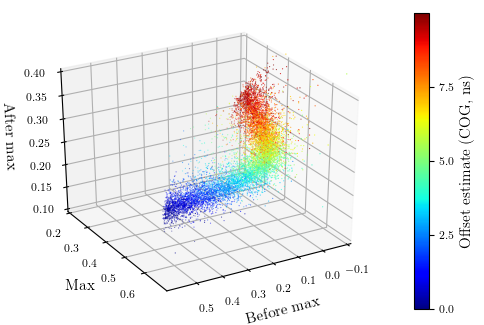

In [142]:
from mpl_toolkits.mplot3d import Axes3D

x, y, z = wvs[zero_i - 1:zero_i + 2,:]
   
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 60)

p = ax.scatter(x, y, z, marker='.', edgecolors='none', s=3, 
               c=data['offset_est_cog'].values[:maxn], 
               cmap=plt.cm.jet,
               vmin=0, vmax=10)

ax.set_xlim(-0.1, 0.6)
ax.set_ylim(0.2, 0.7)
ax.set_zlim(0.1, 0.4)
ax.set_yticks(np.linspace(0.2, 0.6, 5))
ax.set_xlabel('Before max')
ax.set_ylabel('Max')
ax.set_zlabel('After max')

fig.colorbar(p, label='Offset estimate (COG, ns)', ticks=[-2.5, 0, 2.5, 5, 7.5])

plt.tight_layout()
plt.show()

Looks like COG is parametrizing some clear structure in the data at least. To determine if it might work, and how accurate it is, you'd need to try it on simulated waveforms.